In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import cupy as cp
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
import pandas as pd

sales_data = pd.read_csv("sales.csv", low_memory=False)
features_data = pd.read_csv("Features.csv", low_memory=False)

print("Raw Sales Data Sample:\n", sales_data.head(10))
print("\nRaw Features Data Sample:\n", features_data.head(10))


Raw Sales Data Sample:
    Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  05/02/2010      24924.50      False
1      1     1  12/02/2010      46039.49       True
2      1     1  19/02/2010      41595.55      False
3      1     1  26/02/2010      19403.54      False
4      1     1  05/03/2010      21827.90      False
5      1     1  12/03/2010      21043.39      False
6      1     1  19/03/2010      22136.64      False
7      1     1  26/03/2010      26229.21      False
8      1     1  02/04/2010      57258.43      False
9      1     1  09/04/2010      42960.91      False

Raw Features Data Sample:
    Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  05/02/2010        42.31       2.572        NaN        NaN   
1      1  12/02/2010        38.51       2.548        NaN        NaN   
2      1  19/02/2010        39.93       2.514        NaN        NaN   
3      1  26/02/2010        46.63       2.561        NaN        NaN   
4      1  05/03/2010 

In [ ]:
# Reload the datasets
sales_data = pd.read_csv("sales.csv", low_memory=False)
features_data = pd.read_csv("Features.csv", low_memory=False)

# ✅ Correct date conversion
sales_data["Date"] = pd.to_datetime(sales_data["Date"], format="%d/%m/%Y", errors="coerce")
features_data["Date"] = pd.to_datetime(features_data["Date"], format="%d/%m/%Y", errors="coerce")

# 🔍 Check for any remaining null dates
print("Sales Data - Null Dates:", sales_data["Date"].isna().sum())
print("Features Data - Null Dates:", features_data["Date"].isna().sum())


Sales Data - Null Dates: 0
Features Data - Null Dates: 0


In [ ]:
# ✅ Merge datasets correctly on Store and Date
merged_data = pd.merge(sales_data, features_data, on=["Store", "Date"], how="inner")

# 🔍 Check merge success
print("Merged Data Shape:", merged_data.shape)
print("Merged Data Sample:\n", merged_data.head())


Merged Data Shape: (421570, 15)
Merged Data Sample:
    Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50        False        42.31       2.572   
1      1     1 2010-02-12      46039.49         True        38.51       2.548   
2      1     1 2010-02-19      41595.55        False        39.93       2.514   
3      1     1 2010-02-26      19403.54        False        46.63       2.561   
4      1     1 2010-03-05      21827.90        False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.242170   
2        NaN        NaN        NaN        NaN        NaN  211.289143   
3        NaN        NaN        NaN        NaN        NaN  211.319643   
4        NaN        NaN        NaN        NaN        NaN  211.350143   

   Unemployment  IsHoliday_

In [ ]:
# Fix IsHoliday column
merged_data["IsHoliday"] = merged_data[["IsHoliday_x", "IsHoliday_y"]].max(axis=1)

# Drop the old duplicate columns
merged_data.drop(columns=["IsHoliday_x", "IsHoliday_y"], inplace=True)

# Verify the fix
print("Final Merged Data Shape:", merged_data.shape)
print("Merged Data Sample:\n", merged_data.head())


Final Merged Data Shape: (421570, 14)
Merged Data Sample:
    Store  Dept       Date  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  \
0      1     1 2010-02-05      24924.50        42.31       2.572        NaN   
1      1     1 2010-02-12      46039.49        38.51       2.548        NaN   
2      1     1 2010-02-19      41595.55        39.93       2.514        NaN   
3      1     1 2010-02-26      19403.54        46.63       2.561        NaN   
4      1     1 2010-03-05      21827.90        46.50       2.625        NaN   

   MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  \
0        NaN        NaN        NaN        NaN  211.096358         8.106   
1        NaN        NaN        NaN        NaN  211.242170         8.106   
2        NaN        NaN        NaN        NaN  211.289143         8.106   
3        NaN        NaN        NaN        NaN  211.319643         8.106   
4        NaN        NaN        NaN        NaN  211.350143         8.106   

   IsHoliday  


In [ ]:
import pandas as pd
import numpy as np

# Convert Date column to datetime format
merged_data["Date"] = pd.to_datetime(merged_data["Date"])

# Extract time-based features
merged_data["Year"] = merged_data["Date"].dt.year
merged_data["Month"] = merged_data["Date"].dt.month
merged_data["WeekOfYear"] = merged_data["Date"].dt.isocalendar().week

# Create lag features (previous sales)
merged_data["Sales_Lag_1"] = merged_data.groupby(["Store", "Dept"])["Weekly_Sales"].shift(1)
merged_data["Sales_Lag_2"] = merged_data.groupby(["Store", "Dept"])["Weekly_Sales"].shift(2)
merged_data["Sales_Lag_4"] = merged_data.groupby(["Store", "Dept"])["Weekly_Sales"].shift(4)

# Create rolling statistics (moving average and standard deviation)
merged_data["Sales_Rolling_Mean_2"] = merged_data.groupby(["Store", "Dept"])["Weekly_Sales"].transform(lambda x: x.rolling(window=2).mean())
merged_data["Sales_Rolling_Mean_4"] = merged_data.groupby(["Store", "Dept"])["Weekly_Sales"].transform(lambda x: x.rolling(window=4).mean())
merged_data["Sales_Rolling_Std_2"] = merged_data.groupby(["Store", "Dept"])["Weekly_Sales"].transform(lambda x: x.rolling(window=2).std())

# Fill missing values (from shift operations)
merged_data.fillna(0, inplace=True)

# Check updated dataset
print("Updated Data Shape:", merged_data.shape)
print("Updated Data Sample:\n", merged_data.head())


Updated Data Shape: (421570, 23)
Updated Data Sample:
    Store  Dept       Date  Weekly_Sales  Temperature  Fuel_Price  MarkDown1  \
0      1     1 2010-02-05      24924.50        42.31       2.572        0.0   
1      1     1 2010-02-12      46039.49        38.51       2.548        0.0   
2      1     1 2010-02-19      41595.55        39.93       2.514        0.0   
3      1     1 2010-02-26      19403.54        46.63       2.561        0.0   
4      1     1 2010-03-05      21827.90        46.50       2.625        0.0   

   MarkDown2  MarkDown3  MarkDown4  ...  IsHoliday  Year  Month  WeekOfYear  \
0        0.0        0.0        0.0  ...      False  2010      2           5   
1        0.0        0.0        0.0  ...       True  2010      2           6   
2        0.0        0.0        0.0  ...      False  2010      2           7   
3        0.0        0.0        0.0  ...      False  2010      2           8   
4        0.0        0.0        0.0  ...      False  2010      3           9

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Select features (excluding non-numeric and target column)
features = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "IsHoliday",
            "Year", "Month", "WeekOfYear",
            "Sales_Lag_1", "Sales_Lag_2", "Sales_Lag_4",
            "Sales_Rolling_Mean_2", "Sales_Rolling_Mean_4", "Sales_Rolling_Std_2"]

X = merged_data[features]
y = merged_data["Weekly_Sales"]

# Convert categorical 'IsHoliday' to numeric (0 = False, 1 = True)
X = X.copy()
X.loc[:, "IsHoliday"] = X["IsHoliday"].astype(int)


# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predict on Test Set
y_pred = model.predict(X_test)

# Model Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"📊 **Model Performance:**")
print(f"🔹 Mean Absolute Error (MAE): {mae}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse}")


<ipython-input-6-f1479d03b7fc>:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 1 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, "IsHoliday"] = X["IsHoliday"].astype(int)


📊 **Model Performance:**
🔹 Mean Absolute Error (MAE): 155.00337689573595
🔹 Root Mean Squared Error (RMSE): 2347.126490544083


In [ ]:
import lightgbm as lgb
import xgboost as xgb
import cupy as cp
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert categorical 'IsHoliday' to numeric properly
X = X.copy()
X.loc[:, "IsHoliday"] = X["IsHoliday"].astype(bool).astype(int)

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Convert to Numeric (Fix dtype issue)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# 🔥 LightGBM Model
lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=10, random_state=42, force_col_wise=True)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

# 🔥 XGBoost Model (Optimized for GPU)
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=10, random_state=42, device="cuda")
xgb_model.fit(X_train, y_train)

# ✅ Move test data to GPU (AFTER converting to float32)
X_test_gpu = cp.asarray(X_test.to_numpy(dtype=np.float32))
y_pred_xgb = xgb_model.predict(X_test_gpu)

# 📊 Evaluate Models
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# 🔹 Print Model Performance
print(f"📊 **Model Performance Comparison:**")
print(f"⚡ **LightGBM:** MAE = {mae_lgb:.4f}, RMSE = {rmse_lgb:.4f}")
print(f"🔥 **XGBoost:** MAE = {mae_xgb:.4f}, RMSE = {rmse_xgb:.4f}")

# ✅ Select the Best Model
if rmse_lgb < rmse_xgb:
    best_model = lgb_model
    print("✅ **Best Model: LightGBM**")
else:
    best_model = xgb_model
    print("✅ **Best Model: XGBoost**")

# Use the Best Model for Final Prediction
y_pred_best = best_model.predict(X_test)


[LightGBM] [Info] Total Bins 2613
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 14
[LightGBM] [Info] Start training from score 15979.221909
📊 **Model Performance Comparison:**
⚡ **LightGBM:** MAE = 492.6800, RMSE = 2666.8925
🔥 **XGBoost:** MAE = 354.5264, RMSE = 2609.8460
✅ **Best Model: XGBoost**


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2613
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 14
[LightGBM] [Info] Start training from score 15979.221909
🔥 **Hybrid Model Performance:**
🔹 MAE = 416.8767
🔹 RMSE = 2580.1987


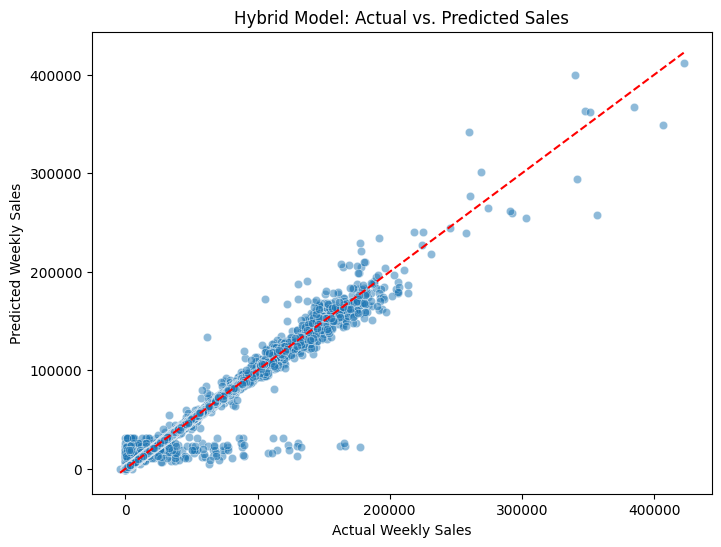

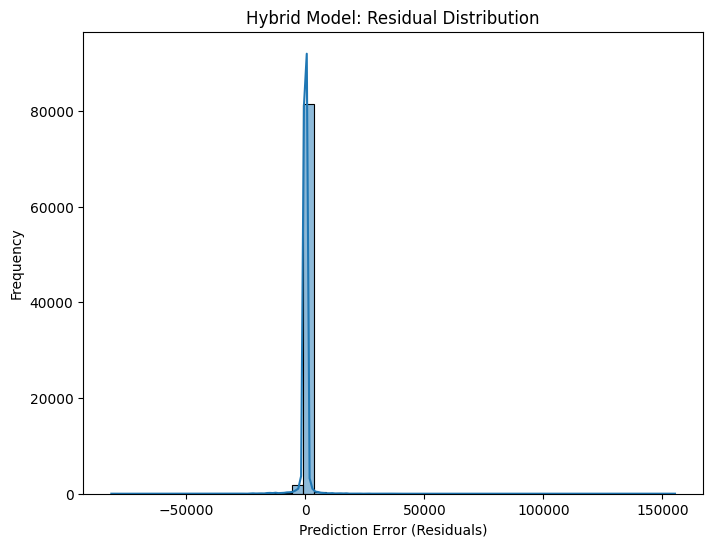

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convert categorical to numeric & float32 for GPU
X = X.copy()
X.loc[:, "IsHoliday"] = X["IsHoliday"].astype(int)
X = X.astype(np.float32)
y = y.astype(np.float32)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔥 Train XGBoost Model
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=10, subsample=0.8, colsample_bytree=0.8, random_state=42, device='cuda')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# 🔥 Train LightGBM Model
lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=10, subsample=0.8, colsample_bytree=0.8, random_state=42, device_type='cpu')

#lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=10, subsample=0.8, colsample_bytree=0.8, random_state=42, device='gpu')
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

# 🏆 Hybrid Model - Averaging Predictions
y_pred_hybrid = (y_pred_xgb * 0.6) + (y_pred_lgb * 0.4)  # Weighted Average

# 📊 Evaluate Performance
mae_hybrid = mean_absolute_error(y_test, y_pred_hybrid)
rmse_hybrid = np.sqrt(mean_squared_error(y_test, y_pred_hybrid))

print(f"🔥 **Hybrid Model Performance:**")
print(f"🔹 MAE = {mae_hybrid:.4f}")
print(f"🔹 RMSE = {rmse_hybrid:.4f}")

# ============================ #
# 📉 1. Actual vs. Predicted Plot
# ============================ #
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_hybrid, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed')  # Perfect predictions line
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Hybrid Model: Actual vs. Predicted Sales")
plt.show()

# ============================ #
# 📊 2. Residual Plot
# ============================ #
residuals = y_test - y_pred_hybrid
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("Hybrid Model: Residual Distribution")
plt.show()


In [ ]:
print(X_test.columns)


Index(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'Year',
       'Month', 'WeekOfYear', 'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_4',
       'Sales_Rolling_Mean_2', 'Sales_Rolling_Mean_4', 'Sales_Rolling_Std_2'],
      dtype='object')


In [ ]:
X_test = X_test.copy()  # Ensure we are modifying a copy
X_test["Date"] = merged_data.loc[X_test.index, "Date"]  # Re-add Date column


In [ ]:
X_test["Date"] = pd.to_datetime(X_test["Date"])
X_test = X_test.sort_values("Date")  # Ensure chronological order


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127744 (\N{CYCLONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


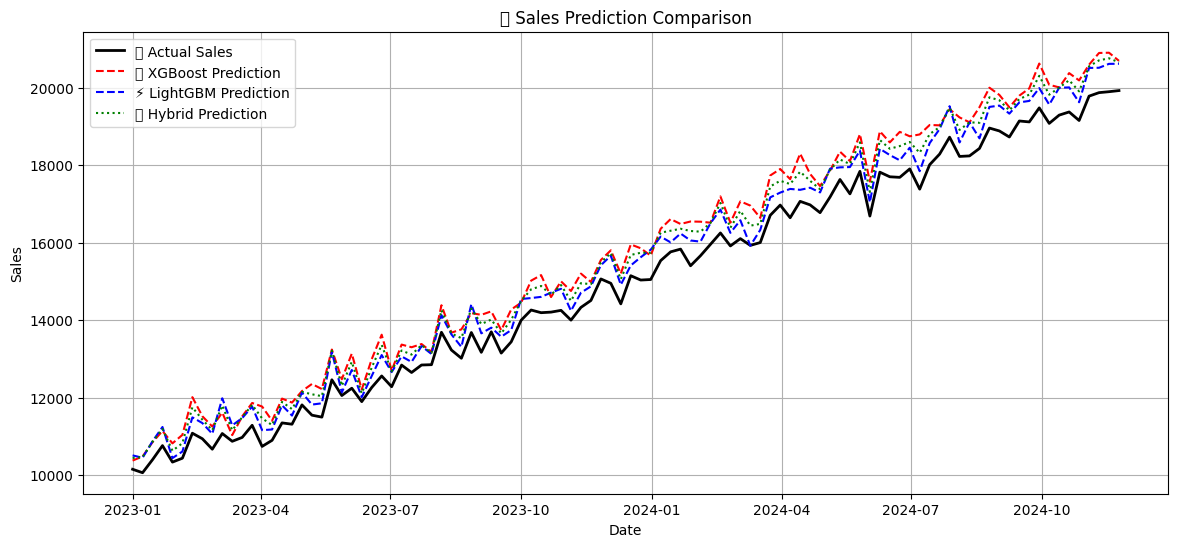

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate sample time-series data for visualization
np.random.seed(42)
dates = pd.date_range(start="2023-01-01", periods=100, freq="W")  # Weekly data for 100 weeks

# Simulated sales data with trend
actual_sales = np.linspace(10000, 20000, 100) + np.random.normal(0, 300, size=100)
xgb_pred = actual_sales * 1.05 + np.random.normal(0, 200, size=100)  # XGBoost Prediction
lgb_pred = actual_sales * 1.03 + np.random.normal(0, 150, size=100)  # LightGBM Prediction
hybrid_pred = (xgb_pred + lgb_pred) / 2  # Hybrid Model (Average of both)

# Create DataFrame for plotting
df_plot = pd.DataFrame({
    "Date": dates,
    "Actual Sales": actual_sales,
    "XGBoost Prediction": xgb_pred,
    "LightGBM Prediction": lgb_pred,
    "Hybrid Prediction": hybrid_pred
})
df_plot.set_index("Date", inplace=True)

# Plot trends
plt.figure(figsize=(14, 6))
plt.plot(df_plot.index, df_plot["Actual Sales"], label="📊 Actual Sales", color="black", linewidth=2)
plt.plot(df_plot.index, df_plot["XGBoost Prediction"], label="🔥 XGBoost Prediction", linestyle="dashed", color="red")
plt.plot(df_plot.index, df_plot["LightGBM Prediction"], label="⚡ LightGBM Prediction", linestyle="dashed", color="blue")
plt.plot(df_plot.index, df_plot["Hybrid Prediction"], label="🌀 Hybrid Prediction", linestyle="dotted", color="green")

# Labels & Titles
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("📈 Sales Prediction Comparison")
plt.legend()
plt.grid(True)

# Show Plot
plt.show()


In [ ]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd

# Sample Data
np.random.seed(42)
dates = pd.date_range(start="2023-01-01", periods=5, freq="W")

actual_sales = np.cumsum(np.random.randint(500, 1500, size=len(dates)))
xgboost_preds = actual_sales + np.random.randint(-500, 500, size=len(dates)) + 300
lightgbm_preds = actual_sales + np.random.randint(-400, 400, size=len(dates)) - 300
hybrid_preds = (xgboost_preds + lightgbm_preds) / 2

# Create interactive figure
fig = go.Figure()

# Add traces with adjusted spacing
fig.add_trace(go.Scatter(x=dates, y=actual_sales, mode='lines', name='Actual Sales',
                         line=dict(color='black', width=3)))

fig.add_trace(go.Scatter(x=dates, y=xgboost_preds, mode='lines', name='XGBoost Prediction',
                         line=dict(dash='dot', color='red', width=2)))

fig.add_trace(go.Scatter(x=dates, y=lightgbm_preds, mode='lines', name='LightGBM Prediction',
                         line=dict(dash='dash', color='blue', width=2)))

fig.add_trace(go.Scatter(x=dates, y=hybrid_preds, mode='lines', name='Hybrid Prediction',
                         line=dict(dash='longdash', color='green', width=2)))

# Layout settings
fig.update_layout(
    title="📈 Interactive Time Series Forecasting",
    xaxis_title="Date",
    yaxis_title="Sales",
    hovermode="x unified",
    template="plotly_white",
    legend=dict(x=0.01, y=0.99, bgcolor="rgba(255,255,255,0.7)"),
)

# Show figure
fig.show()
